In [1]:
import os
import nodes
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from comfy import sd
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Total VRAM 40337 MB, total RAM 515700 MB
Set vram state to: NORMAL_VRAM
Device: cuda:0 NVIDIA A100-SXM4-40GB : native
VAE dtype: torch.bfloat16
Using pytorch cross attention


In [2]:
#CheckpointLoader

ckpt_path = "/dlabscratch1/wendler/models/sdxl-turbo/sd_xl_turbo_1.0_fp16.safetensors"#folder_paths.get_full_path("checkpoints", ckpt_name)
out = sd.load_checkpoint_guess_config(ckpt_path, output_vae=True, output_clip=True, output_clipvision=True, embedding_directory="./embeddings")
(model, clip, vae, clip_vision) = out

print(out)
print(clip_vision)
print(out)
print(model)

model_type EPS
Using pytorch attention in VAE
Using pytorch attention in VAE
clip missing: ['clip_l.logit_scale', 'clip_l.transformer.text_projection.weight']


(<comfy.model_patcher.ModelPatcher object at 0x7f837f9336d0>, <comfy.sd.CLIP object at 0x7f837ef93b50>, <comfy.sd.VAE object at 0x7f837f118a10>, None)
None
(<comfy.model_patcher.ModelPatcher object at 0x7f837f9336d0>, <comfy.sd.CLIP object at 0x7f837ef93b50>, <comfy.sd.VAE object at 0x7f837f118a10>, None)


In [3]:
# CLIP Text Encode

text = "dog"
tokens = clip.tokenize(text)
cond, pooled = clip.encode_from_tokens(tokens, return_pooled=True)
positive = [[cond, {"pooled_output": pooled}]]

text = "text, watermark"
tokens = clip.tokenize(text)
cond, pooled = clip.encode_from_tokens(tokens, return_pooled=True)
negative = [[cond, {"pooled_output": pooled}]]


Requested to load SDXLClipModel
Loading 1 new model


In [4]:
print(pooled.shape)
print(cond.shape)

torch.Size([1, 1280])
torch.Size([1, 77, 2048])


In [5]:
# Empty Latent Image

batch_size = 2
height, width = 512, 512

latent = torch.zeros([batch_size, 4, height // 8, width // 8], device=device)
latent_image = {"samples":latent}

In [6]:
# KSampler

seed = random.randint(0, 0xffffffffffffffff)
steps = 30
cfg = 8.0
sampler_name = "euler"
scheduler = "normal"
denoise = 1.0

samples = nodes.common_ksampler(model, seed, steps, cfg, sampler_name, scheduler, positive, negative, latent_image, denoise=denoise)[0]

Requested to load SDXL
Loading 1 new model


  0%|          | 0/30 [00:00<?, ?it/s]

In [7]:
# Latent Safety Filter

import open_clip
from sklearn.metrics.pairwise import cosine_similarity

print(samples["samples"].shape) # torch.Size([1, 4, 64, 64])

models = {'B-8': {'model_name':'Latent-ViT-B-8-512',
                  'pretrained':'/dlabdata1/wendler/models/latent-clip-b-8.pt'},
          'B-4-plus':{'model_name':'Latent-ViT-B-4-512-plus',
                      'pretrained':'/dlabdata1/wendler/models/latent-clip-b-4-plus.pt'}}
size = 'B-4-plus'
model_name = models[size]['model_name']
pretrained = models[size]['pretrained']
model_latent, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
tokenizer_latent = open_clip.get_tokenizer(model_name)

/dlabscratch1/jabecker/conda/envs/test_env/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loaded Latent-ViT-B-4-512-plus model config.


torch.Size([2, 4, 64, 64])


Loading pretrained Latent-ViT-B-4-512-plus weights (/dlabdata1/wendler/models/latent-clip-b-4-plus.pt).


In [8]:
image_features = model_latent.encode_image(samples["samples"])

sensitive_word = "cat"
text_features = model_latent.encode_text(tokenizer_latent([f"an image of {sensitive_word}", f"an image of no {sensitive_word}"]))
print(image_features.shape)
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)

print(text_probs[0][0].item())
print(text_probs)
#text_features = model_latent.encode_text(captions.cuda())
print(image_features.shape)
image_features_np = image_features.detach().numpy()
text_features_np = text_features.detach().numpy()

similarity_score = cosine_similarity(image_features_np, text_features_np)
print(f"Similarity ({text}):\t{similarity_score}")

torch.Size([2, 640])
0.8656362295150757
tensor([[0.8656, 0.1344],
        [0.8548, 0.1452]], grad_fn=<SoftmaxBackward0>)
torch.Size([2, 640])
Similarity (text, watermark):	[[0.16905537 0.1504263 ]
 [0.15587994 0.13815394]]


In [9]:
# VAE Decode

images = vae.decode(samples["samples"])

Requested to load AutoencoderKL
Loading 1 new model


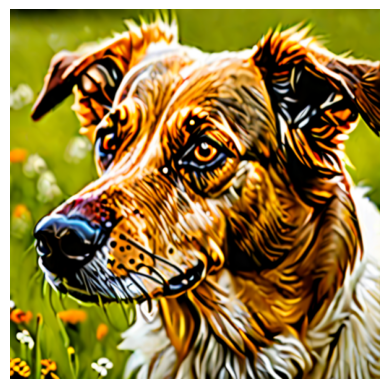

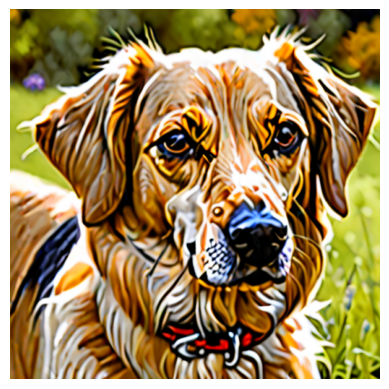

In [10]:
# Save Image

#filename_prefix += self.prefix_append
#full_output_folder, filename, counter, subfolder, filename_prefix = folder_paths.get_save_image_path(filename_prefix, self.output_dir, images[0].shape[1], images[0].shape[0])
results = list()
for (batch_number, image) in enumerate(images):
    i = 255. * image.detach().numpy()
    img = Image.fromarray(np.clip(i, 0, 255).astype(np.uint8))
    metadata = None
    """
    if not args.disable_metadata:
        metadata = PngInfo()
        if prompt is not None:
            metadata.add_text("prompt", json.dumps(prompt))
        if extra_pnginfo is not None:
            for x in extra_pnginfo:
                metadata.add_text(x, json.dumps(extra_pnginfo[x]))
    filename_with_batch_num = filename.replace("%batch_num%", str(batch_number))
    file = f"{filename_with_batch_num}_{counter:05}_.png"
    img.save(os.path.join(full_output_folder, file), pnginfo=metadata, compress_level=self.compress_level)
    results.append({
        "filename": file,
        "subfolder": subfolder,
        "type": self.type
    })
    counter += 1
    """
    plt.imshow(img)
    plt.axis('off')  # Turn off axis
    plt.show()

In [11]:
# Safety Filter

import requests
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer
from sklearn.metrics.pairwise import cosine_similarity

def get_model_info(model_ID, device):
	model = CLIPModel.from_pretrained(model_ID).to(device)
	processor = CLIPProcessor.from_pretrained(model_ID)
	tokenizer = CLIPTokenizer.from_pretrained(model_ID)
	return model, processor, tokenizer

def get_single_text_embedding(text): 
    inputs = tokenizer(text, return_tensors = "pt").to(device)
    text_embeddings = model_clip.get_text_features(**inputs)
    embedding_as_np = text_embeddings.cpu().detach().numpy()
    return embedding_as_np

def get_single_image_embedding(my_image):
    image = processor(
    		text = None,
    		images = my_image,
    		return_tensors="pt"
    		)["pixel_values"].to(device)
    embedding = model_clip.get_image_features(image)
    embedding_as_np = embedding.cpu().detach().numpy()
    return embedding_as_np
    
device = "cuda" if torch.cuda.is_available() else "cpu"

model_IDs = ["openai/clip-vit-base-patch32", "openai/clip-vit-large-patch14"]
model_ID = model_IDs[1]
model_clip, processor, tokenizer = get_model_info(model_ID, device)

#url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = img #Image.open(requests.get(url, stream=True).raw)
image_embedding = get_single_image_embedding(image)

texts=["cat", "no cat"]

for text in texts:
    text_embedding = get_single_text_embedding(text)
    similarity_score = cosine_similarity(image_embedding, text_embedding)[0][0]
    print(f"Similarity ({text}):\t{similarity_score}")

inputs = processor(text="cat", images=image, return_tensors="pt", padding=True).to(device)
outputs = model_clip(**inputs)

logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

print(probs)
print(logits_per_image)

Similarity (cat):	0.12320650368928909
Similarity (no cat):	0.1302909255027771
tensor([[1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[12.3207]], device='cuda:0', grad_fn=<TBackward0>)


In [12]:
logits_per_image.item()

12.32065200805664

In [13]:
from diffusers import StableDiffusionXLPipeline, EulerAncestralDiscreteScheduler
import torch

pipeline = StableDiffusionXLPipeline.from_single_file(
    "/dlabscratch1/wendler/models/sdxl-turbo/sd_xl_turbo_1.0.safetensors",
    torch_dtype=torch.float16, variant="fp16")
pipeline = pipeline.to("cuda")
pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(pipeline.scheduler.config, timestep_spacing="trailing")

/dlabscratch1/jabecker/conda/envs/test_env/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/dlabscratch1/jabecker/conda/envs/test_env/lib/python3.11/site-packages/diffusers/pipelines/pipeline_utils.py:761: FutureWarning: `torch_dtype` is deprecated and will be removed in version 0.25.0. 
  deprecate("torch_dtype", "0.25.0", "")


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 39.39 GiB of which 81.50 MiB is free. Process 2457010 has 19.18 GiB memory in use. Process 2464208 has 20.13 GiB memory in use. Of the allocated memory 19.37 GiB is allocated by PyTorch, and 246.71 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)